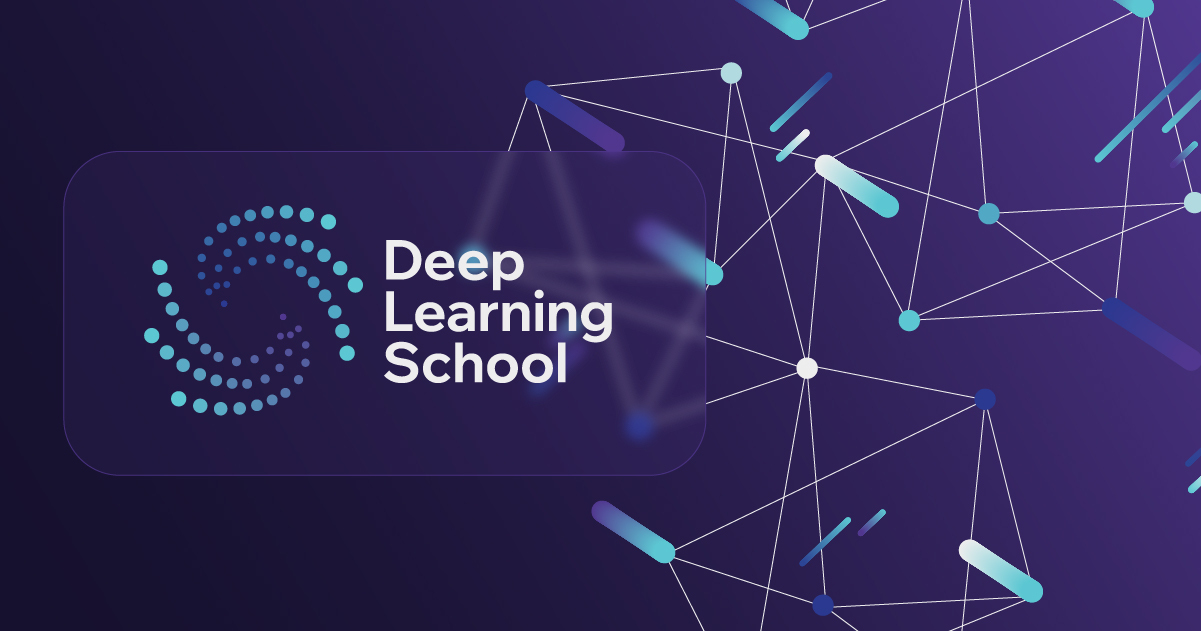


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Классификация изображений</b></h3>


# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

### Установка зависимостей

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np
from torch.optim import Adamax
from torch.optim.adamw import adamw


train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
#!pip install google

In [3]:
#from google.colab import drive
#drive.mount('/content/gdrive/')

In [4]:
#!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [5]:
#!ls journey-springfield

In [6]:
#!ls data

In [7]:
#!ls data/train

In [2]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [9]:
# это пакет для проверки версий других пакетов
import pkg_resources

In [10]:
!python --version

Python 3.13.3


In [11]:
for b in ['torch', 'torchvision', 'tqdm', 'matplotlib', 'seaborn', 'Pillow']:
    print(b + ' version: '+ pkg_resources.get_distribution(b).version)

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124
tqdm version: 4.67.1
matplotlib version: 3.10.1
seaborn version: 0.13.2
Pillow version: 11.2.1


#### Версии питона и библиотек, на которых работал эталонный ноутбук:

Python 3.11.11

torch version: 2.5.1+cu124

torchvision version: 0.20.1+cu124

tqdm version: 4.67.1

matplotlib version: 3.10.0

seaborn version: 0.13.2

Pillow version: 11.1.0


In [3]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Полезная статья, которой мы вдохновились при создании класса `SimpsonsDataset`:

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

`ToTensor` конвертирует  `PIL Image` с параметрами в диапазоне $[0, 255]$ (как все пиксели) в `FloatTensor` размера ($C \times H \times W$) $[0,1]$ , затем производится масштабирование:
$\text{input} = \frac{\text{input} - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размеру (это делает метод  _prepare_sample).

In [9]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [14]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('journey-springfield/train/')
TEST_DIR = Path('journey-springfield/testset/testset')

In [11]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [12]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25,
                                          stratify=train_val_labels)

In [13]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [19]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

**!** Обратите внимание, что возможно, датасет требует дополнительной фильтрации, так как лейблы не всегда точно соответствуют картинкам.

Давайте посмотрим на наших героев внутри датасета.

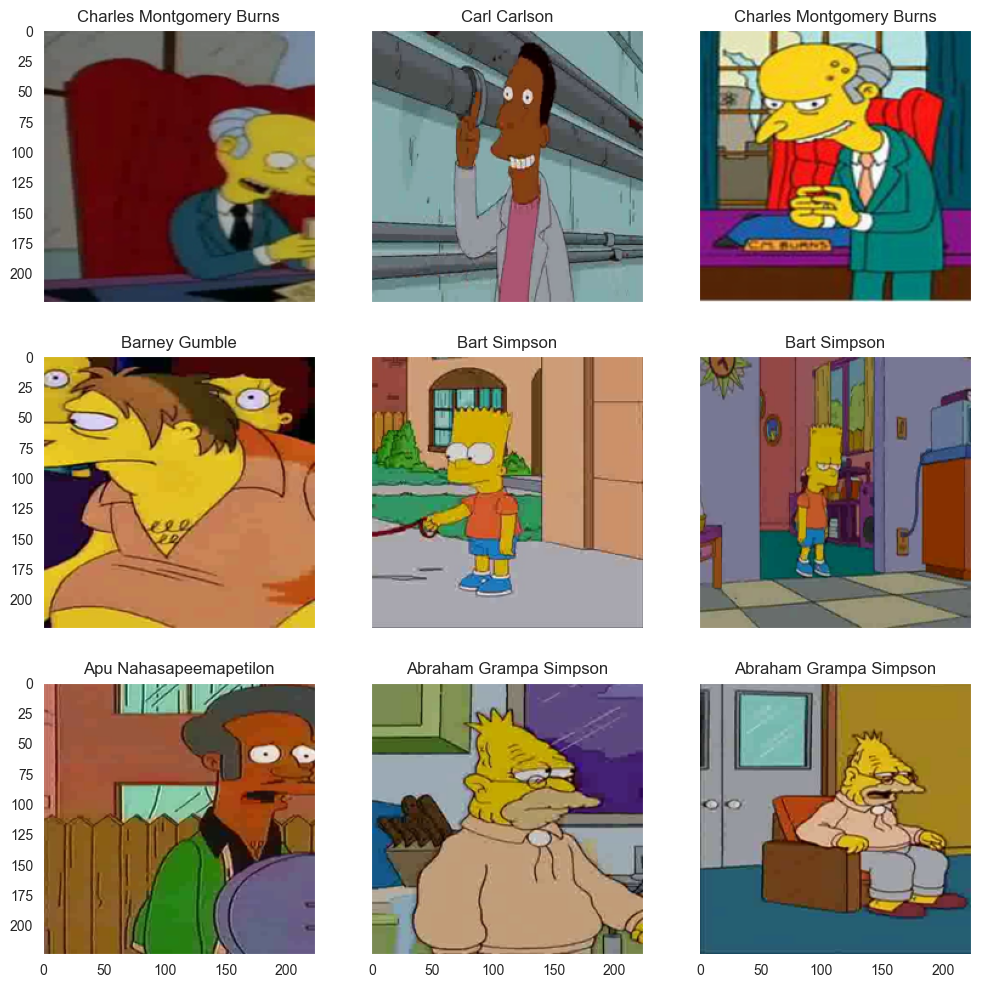

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle.

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: $3\times 224 \times 224$
2.размерности после слоя:  $8 \times 111 \times 111$
3. $16 \times 54 \times 54$
4. $32 \times 26 \times 26$
5. $64 \times 12 \times 12$
6. выход: $96 \times 5 \times 5$

О том, как работают свёртки подробней можно прочитать в документации Pytorch на функцию `Conv2d`:

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Калькулятор свёрток:

https://madebyollin.github.io/convnet-calculator/

#### Модель

In [21]:
class SimpleCnn(nn.Module):
    """
    Очень простая сверточная нейронная сеть для классификации изображений.

    Эта сеть состоит из пяти сверточных слоев, каждый из которых
    включает в себя операцию свертки, функцию активации ReLU и операцию
    пулинга (max-pooling). На выходе используется полносвязный слой
    для классификации на заданное количество классов.

    Параметры:
    ----------
    n_classes : int
        Количество классов для классификации.

    Примечание:
    ----------
    Входные изображения должны иметь размерность (3, H, W), где
    3 - слои rgb для цветной картинки, а H и W - высота и ширина изображения,
    соответственно. Размер выходного тензора будет равен (n_classes).

    Методы:
    -------
    forward(x):
        Пропускает входные данные через сеть и возвращает логиты для
        каждого класса.
    """

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

#### Функция обучения:

In [14]:
def fit_epoch(model, train_loader, criterion, optimizer):
    """
    Функция обучает модель на одной эпохе, используя предоставленный dataloader.

    Эта функция проходит по всем данным в `train_loader`, выполняет шаг моделью (forward),
    вычисляет лосс, выполняет обратное распространение с помощью заданного
    оптимизатора и обновляет веса модели.
    В конце эпохи возвращаются средний лосс и
    точность на обучающем наборе данных.

    Параметры:
    ----------
    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    train_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных и
        соответствующих меток. Должен возвращать кортежи (inputs, labels).

    criterion : nn.Module
        Функция потерь, используемая для вычисления ошибки между
        предсказаниями модели и истинными метками.

    optimizer : torch.optim.Optimizer
        Оптимизатор, используемый для обновления весов модели на основе
        градиентов, вычисленных в процессе обучения.

    Функция возвращает:
    ----------
    tuple
        Кортеж, содержащий средний лосс (train_loss) и точность (train_acc)
        на обучающем наборе данных за текущую эпоху.
    """

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

#### Функция валидации:

In [15]:
def eval_epoch(model, val_loader, criterion):
    """
    Функция оценивает работу модели на валидационном наборе данных за одну эпоху.

    Эта функция проходит по всем данным в `val_loader`, выполняет прямое
    распространение, вычисляет лосс и точность модели. В конце эпохи
    возвращаются средний лосс и точность на валидационном наборе данных.

    Параметры:
    ----------
    model : nn.Module
        Модель, которую необходимо оценить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    val_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных и
        соответствующих меток для валидации. Должен возвращать кортежи
        (inputs, labels).

    criterion : nn.Module
        Функция потерь, используемая для вычисления ошибки между
        предсказаниями модели и истинными метками.

    Функция возвращает:
    ----------
    tuple
        Кортеж, содержащий среднюю потерю (val_loss) и точность (val_acc)
        на валидационном наборе данных за текущую эпоху.
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

#### Полный цикл обучения

In [16]:
def train(train_files, val_files, model, epochs, batch_size):
    """
    Функция обучает модель на обучающем наборе данных и оценивает ее на валидационном наборе данных.

    Эта функция создает загрузчики данных для обучающего и валидационного наборов,
    а затем выполняет обучение модели в течение заданного количества эпох.
    В конце каждой эпохи выводятся значения потерь и точности для обучающего и
    валидационного наборов. История обучения сохраняется и возвращается.

    Параметры:
    ----------
    train_files : list
        Список файлов или путей к файлам, содержащим обучающие данные.

    val_files : list
        Список файлов или путей к файлам, содержащим валидационные данные.

    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    epochs : int
        Количество эпох для обучения модели.

    batch_size : int
        Размер батча, используемый для загрузки данных.

    Возвращает:
    ----------
    list
        Список, содержащий кортежи (train_loss, train_acc, val_loss, val_acc)
        для каждой эпохи, где:
        - train_loss: средняя потеря на обучающем наборе.
        - train_acc: точность на обучающем наборе.
        - val_loss: средняя потеря на валидационном наборе.
        - val_acc: точность на валидационном наборе.
    """
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

#### Применение модели к данным

In [17]:
def predict(model, test_loader):
    """
    Функция выполняет предсказание классов для тестового набора данных с использованием обученной модели.

    Эта функция принимает модель и загрузчик тестовых данных, применяет модель к
    изображениям и возвращает вероятности предсказанных классов.

    Параметры:
    ----------
    model : nn.Module
        Обученная модель, которая будет использоваться для предсказания.
        Должна быть экземпляром класса PyTorch `nn.Module`.

    test_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных для тестирования.
        Должен возвращать тензоры входных данных.

    Возвращает:
    ----------
    numpy.ndarray
        Массив вероятностей предсказанных классов для каждого примера в тестовом наборе.
        Размерность массива будет (N, C), где N - количество примеров, а C - количество классов.
    """

    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

Запустим обучение сети.

In [18]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [28]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.5007390324207877


epoch:  50%|█████     | 1/2 [01:41<01:41, 101.24s/it]


Epoch 001 train_loss: 2.5007     val_loss 1.8769 train_acc 0.3094 val_acc 0.4918
loss 1.4795532408349263


epoch: 100%|██████████| 2/2 [03:14<00:00, 97.26s/it] 


Epoch 002 train_loss: 1.4796     val_loss 1.2984 train_acc 0.5956 val_acc 0.6569


Построим кривые обучения

In [29]:
loss, acc, val_loss, val_acc = zip(*history)

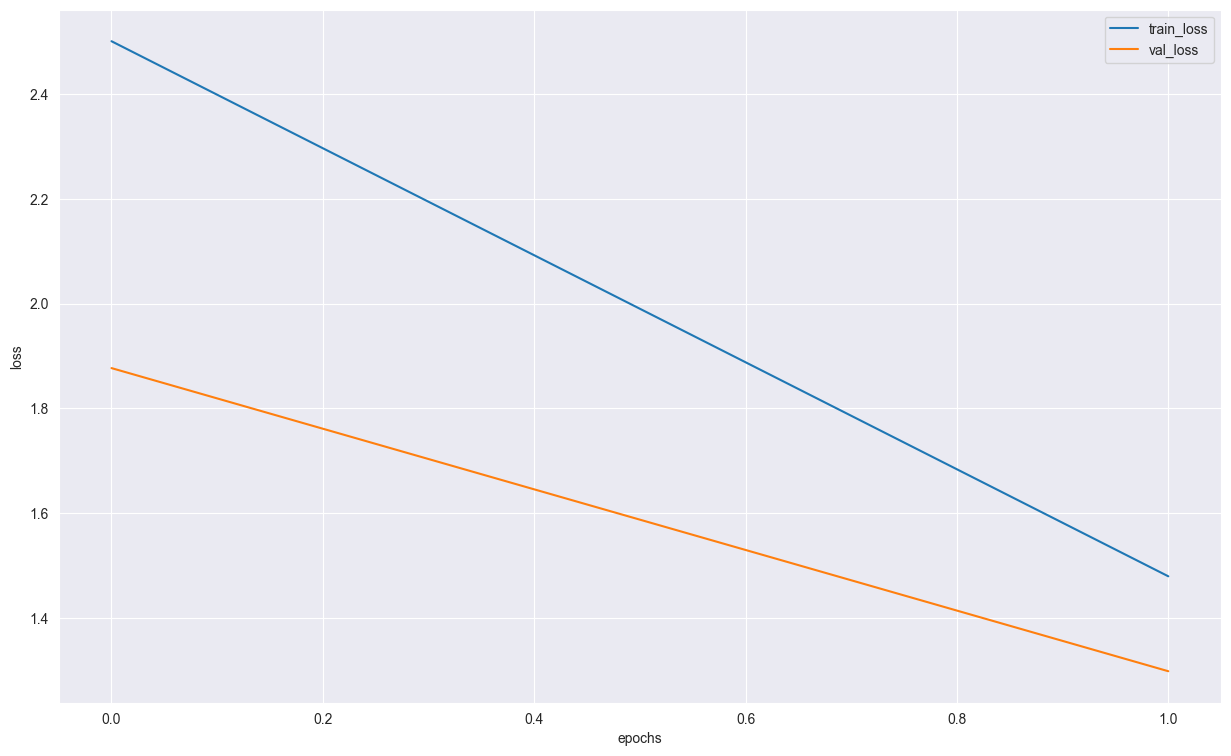

In [30]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит `softmax`, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [32]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [33]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [34]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [35]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [36]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе -- `f1-score`.

Вычислим целевую метрику на валидационной выборке.

In [37]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.7


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

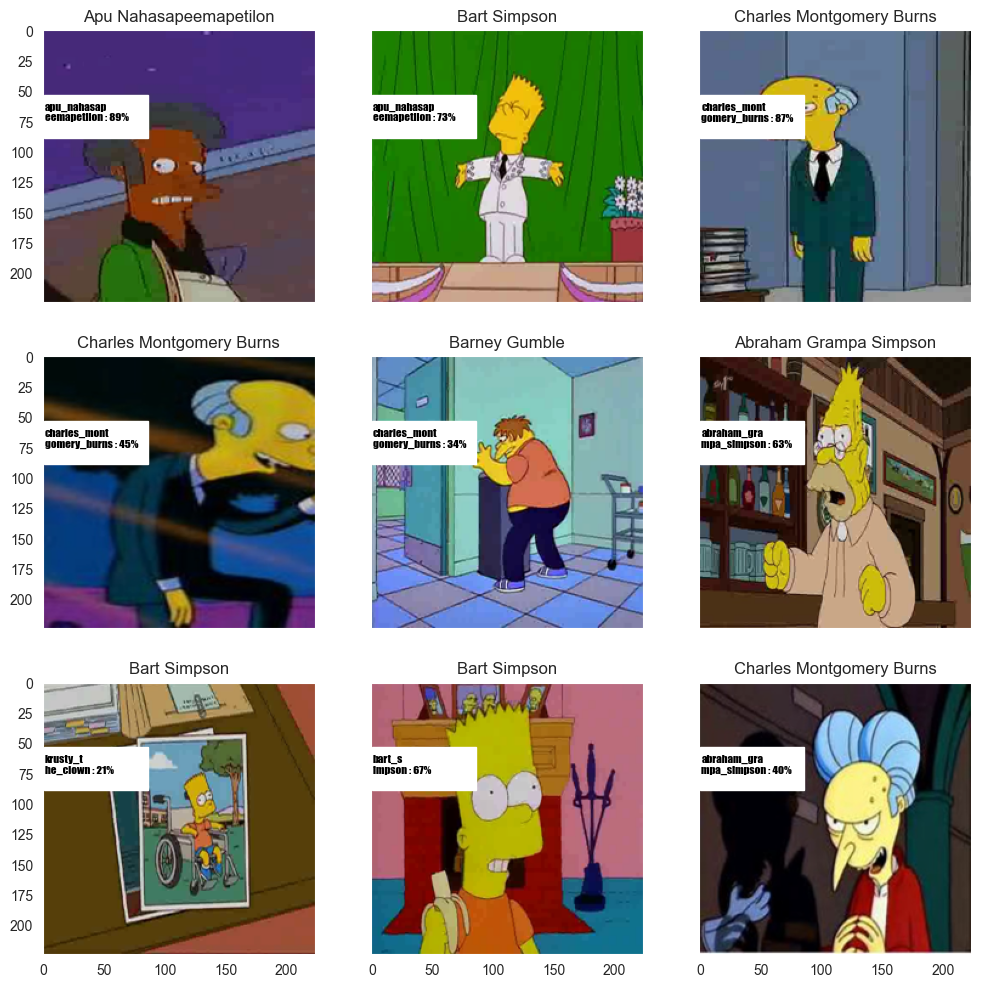

In [38]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [40]:
! ls

"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [41]:
import pandas as pd
my_submit = pd.read_csv("journey-springfield/sample_submission.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [42]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [43]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:
1. Работа с датасетом:
* проверка (EDA) и предобработка;
* дополнение, выравниванике кол-ва картинок в классах - изменять можно как сами картинки, формируя новый датасет, или в класссе SimpsonsDataset;
* с помощью [аугментации](https://habr.com/ru/companies/smartengines/articles/264677/) или [без](https://www.geeksforgeeks.org/python-data-augmentation/);

2. Рабта с архитектурой сети:
* учим дольше и изменяем (подбираем) гиперпараметры: learning rate, batch size, нормализация картинки и вот это всё;
* добавление/удаление свёрточных слоёв;
* кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять!

3. Улучшение оптимизации:
* ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

4. Файнтютинг и трансферлёнинг:
* ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

5. Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


In [19]:

train_transform = transforms.Compose([
    transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomRotation(30),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [20]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, transform=None):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
        if transform is not None:
            self.transform = transform
        else:
            self.transform = train_transform if self.mode == 'train' else val_transform

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        image = Image.open(self.files[index]).convert('RGB')
        x = self.transform(image)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y


In [34]:
from sklearn.metrics import f1_score
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    all_preds = []
    all_labels = []
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

        all_preds.append((preds.cpu().numpy()))
        all_labels.append(labels.cpu().numpy())

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    train_f1 = f1_score(all_labels, all_preds, average='macro')
    return train_loss, train_acc, train_f1

In [35]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    all_preds = []
    all_labels = []
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        all_preds.append((preds.cpu().numpy()))
        all_labels.append(labels.cpu().numpy())

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    val_f1 = f1_score(all_labels, all_preds, average='macro')
    return val_loss, val_acc, val_f1

In [37]:
def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = ("\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f} \
    train_f1 {t_f1:0.4f} val_f1 {v_f1:0.4f}")

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(),lr=0.001)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc, train_f1 = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc, val_f1 = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, train_f1, val_loss, val_acc, val_f1))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, t_f1=train_f1, v_f1=val_f1))

    return history

In [38]:
class MyCNN_MoreLayers2(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=512, out_features=1024),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(in_features=1024, out_features=n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


In [39]:
n_classes = len(np.unique(train_val_labels))
model_ml2 = MyCNN_MoreLayers2(n_classes).to(DEVICE)

In [40]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')
history = train(train_dataset, val_dataset, model=model_ml2, epochs=50, batch_size=128)

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss 3.176947822251269


epoch:   2%|▏         | 1/50 [02:35<2:06:53, 155.38s/it]


Epoch 001 train_loss: 3.1769     val_loss 3.0935 train_acc 0.0957 val_acc 0.1074     train_f1 0.0097 val_f1 0.0046
loss 2.965858976797994


epoch:   4%|▍         | 2/50 [05:09<2:03:31, 154.40s/it]


Epoch 002 train_loss: 2.9659     val_loss 2.5128 train_acc 0.1447 val_acc 0.2619     train_f1 0.0288 val_f1 0.0602
loss 2.2610832336138933


epoch:   6%|▌         | 3/50 [07:42<2:00:37, 153.99s/it]


Epoch 003 train_loss: 2.2611     val_loss 1.8193 train_acc 0.3533 val_acc 0.4668     train_f1 0.1237 val_f1 0.1786
loss 1.6602094154295948


epoch:   8%|▊         | 4/50 [10:22<1:59:44, 156.18s/it]


Epoch 004 train_loss: 1.6602     val_loss 1.2222 train_acc 0.5287 val_acc 0.6406     train_f1 0.2282 val_f1 0.2981
loss 1.2644603476189331


epoch:  10%|█         | 5/50 [12:57<1:57:00, 156.01s/it]


Epoch 005 train_loss: 1.2645     val_loss 0.9992 train_acc 0.6420 val_acc 0.7151     train_f1 0.3003 val_f1 0.3502
loss 1.0670166148054454


epoch:  12%|█▏        | 6/50 [15:34<1:54:29, 156.13s/it]


Epoch 006 train_loss: 1.0670     val_loss 0.9258 train_acc 0.6976 val_acc 0.7382     train_f1 0.3510 val_f1 0.3783
loss 0.9020076742695581


epoch:  14%|█▍        | 7/50 [18:07<1:51:20, 155.36s/it]


Epoch 007 train_loss: 0.9020     val_loss 0.7639 train_acc 0.7434 val_acc 0.7874     train_f1 0.4019 val_f1 0.4520
loss 0.795000208537361


epoch:  16%|█▌        | 8/50 [20:41<1:48:17, 154.71s/it]


Epoch 008 train_loss: 0.7950     val_loss 0.6909 train_acc 0.7741 val_acc 0.8047     train_f1 0.4428 val_f1 0.4712
loss 0.7076614561358244


epoch:  18%|█▊        | 9/50 [23:15<1:45:37, 154.58s/it]


Epoch 009 train_loss: 0.7077     val_loss 0.6645 train_acc 0.7984 val_acc 0.8120     train_f1 0.4820 val_f1 0.4714
loss 0.6326186598102806


epoch:  20%|██        | 10/50 [25:49<1:42:54, 154.36s/it]


Epoch 010 train_loss: 0.6326     val_loss 0.6035 train_acc 0.8208 val_acc 0.8363     train_f1 0.5371 val_f1 0.5705
loss 0.5629464526018205


epoch:  22%|██▏       | 11/50 [28:24<1:40:25, 154.50s/it]


Epoch 011 train_loss: 0.5629     val_loss 0.5687 train_acc 0.8398 val_acc 0.8493     train_f1 0.5776 val_f1 0.5687
loss 0.5346674375400717


epoch:  24%|██▍       | 12/50 [30:58<1:37:48, 154.43s/it]


Epoch 012 train_loss: 0.5347     val_loss 0.5194 train_acc 0.8473 val_acc 0.8579     train_f1 0.6029 val_f1 0.6349
loss 0.47826688539769985


epoch:  26%|██▌       | 13/50 [33:33<1:35:20, 154.61s/it]


Epoch 013 train_loss: 0.4783     val_loss 0.5201 train_acc 0.8656 val_acc 0.8571     train_f1 0.6312 val_f1 0.6516
loss 0.4397439968795547


epoch:  28%|██▊       | 14/50 [36:06<1:32:28, 154.12s/it]


Epoch 014 train_loss: 0.4397     val_loss 0.5055 train_acc 0.8734 val_acc 0.8632     train_f1 0.6656 val_f1 0.6554
loss 0.4134389503331418


epoch:  30%|███       | 15/50 [38:39<1:29:43, 153.82s/it]


Epoch 015 train_loss: 0.4134     val_loss 0.4877 train_acc 0.8822 val_acc 0.8750     train_f1 0.6609 val_f1 0.7024
loss 0.3723256259794045


epoch:  32%|███▏      | 16/50 [41:14<1:27:21, 154.16s/it]


Epoch 016 train_loss: 0.3723     val_loss 0.5153 train_acc 0.8923 val_acc 0.8642     train_f1 0.7066 val_f1 0.6425
loss 0.3587932886857274


epoch:  34%|███▍      | 17/50 [43:50<1:25:02, 154.62s/it]


Epoch 017 train_loss: 0.3588     val_loss 0.4762 train_acc 0.8970 val_acc 0.8829     train_f1 0.7229 val_f1 0.7046
loss 0.3393752058206588


epoch:  36%|███▌      | 18/50 [46:24<1:22:18, 154.34s/it]


Epoch 018 train_loss: 0.3394     val_loss 0.4908 train_acc 0.9030 val_acc 0.8785     train_f1 0.7413 val_f1 0.6977
loss 0.29695833661623217


epoch:  38%|███▊      | 19/50 [48:58<1:19:45, 154.36s/it]


Epoch 019 train_loss: 0.2970     val_loss 0.4846 train_acc 0.9136 val_acc 0.8804     train_f1 0.7551 val_f1 0.7163
loss 0.2838341114198154


epoch:  40%|████      | 20/50 [51:32<1:17:07, 154.26s/it]


Epoch 020 train_loss: 0.2838     val_loss 0.5524 train_acc 0.9166 val_acc 0.8752     train_f1 0.7696 val_f1 0.6689
loss 0.28760275612994285


epoch:  42%|████▏     | 21/50 [54:06<1:14:27, 154.07s/it]


Epoch 021 train_loss: 0.2876     val_loss 0.4868 train_acc 0.9161 val_acc 0.8848     train_f1 0.7649 val_f1 0.7127
loss 0.26830174878863244


epoch:  44%|████▍     | 22/50 [56:41<1:12:01, 154.35s/it]


Epoch 022 train_loss: 0.2683     val_loss 0.4698 train_acc 0.9215 val_acc 0.8848     train_f1 0.7772 val_f1 0.7164
loss 0.24405815285424137


epoch:  46%|████▌     | 23/50 [59:17<1:09:43, 154.95s/it]


Epoch 023 train_loss: 0.2441     val_loss 0.4708 train_acc 0.9280 val_acc 0.8882     train_f1 0.8025 val_f1 0.7195
loss 0.23489549685810865


epoch:  48%|████▊     | 24/50 [1:01:51<1:07:00, 154.62s/it]


Epoch 024 train_loss: 0.2349     val_loss 0.4794 train_acc 0.9306 val_acc 0.8877     train_f1 0.8149 val_f1 0.7324
loss 0.22174544311327588


epoch:  50%|█████     | 25/50 [1:04:25<1:04:26, 154.65s/it]


Epoch 025 train_loss: 0.2217     val_loss 0.5097 train_acc 0.9366 val_acc 0.8869     train_f1 0.8220 val_f1 0.7188
loss 0.20916726402935992


epoch:  52%|█████▏    | 26/50 [1:07:02<1:02:01, 155.08s/it]


Epoch 026 train_loss: 0.2092     val_loss 0.5452 train_acc 0.9373 val_acc 0.8749     train_f1 0.8415 val_f1 0.6894
loss 0.21966078766300173


epoch:  54%|█████▍    | 27/50 [1:09:37<59:26, 155.05s/it]  


Epoch 027 train_loss: 0.2197     val_loss 0.4647 train_acc 0.9354 val_acc 0.8991     train_f1 0.8157 val_f1 0.7511
loss 0.19317053407155388


epoch:  56%|█████▌    | 28/50 [1:12:13<56:59, 155.43s/it]


Epoch 028 train_loss: 0.1932     val_loss 0.4810 train_acc 0.9434 val_acc 0.8907     train_f1 0.8500 val_f1 0.7215
loss 0.17934158970605713


epoch:  58%|█████▊    | 29/50 [1:14:49<54:28, 155.62s/it]


Epoch 029 train_loss: 0.1793     val_loss 0.4745 train_acc 0.9487 val_acc 0.8993     train_f1 0.8462 val_f1 0.7349
loss 0.18846312693383513


epoch:  60%|██████    | 30/50 [1:17:25<51:56, 155.82s/it]


Epoch 030 train_loss: 0.1885     val_loss 0.4738 train_acc 0.9460 val_acc 0.8930     train_f1 0.8594 val_f1 0.7450
loss 0.17518857502468044


epoch:  62%|██████▏   | 31/50 [1:20:01<49:18, 155.72s/it]


Epoch 031 train_loss: 0.1752     val_loss 0.4864 train_acc 0.9461 val_acc 0.8984     train_f1 0.8552 val_f1 0.7380
loss 0.17868781033686235


epoch:  64%|██████▍   | 32/50 [1:22:34<46:29, 154.98s/it]


Epoch 032 train_loss: 0.1787     val_loss 0.5607 train_acc 0.9466 val_acc 0.8890     train_f1 0.8707 val_f1 0.7509
loss 0.17489309941054043


epoch:  66%|██████▌   | 33/50 [1:25:09<43:53, 154.89s/it]


Epoch 033 train_loss: 0.1749     val_loss 0.4905 train_acc 0.9477 val_acc 0.8913     train_f1 0.8618 val_f1 0.7362
loss 0.14554484536905365


epoch:  68%|██████▊   | 34/50 [1:27:45<41:23, 155.22s/it]


Epoch 034 train_loss: 0.1455     val_loss 0.4920 train_acc 0.9582 val_acc 0.8978     train_f1 0.8906 val_f1 0.7421
loss 0.14595426213658533


epoch:  70%|███████   | 35/50 [1:30:19<38:46, 155.07s/it]


Epoch 035 train_loss: 0.1460     val_loss 0.5017 train_acc 0.9560 val_acc 0.8976     train_f1 0.8964 val_f1 0.7392
loss 0.1480967697757271


epoch:  72%|███████▏  | 36/50 [1:32:56<36:17, 155.54s/it]


Epoch 036 train_loss: 0.1481     val_loss 0.5090 train_acc 0.9578 val_acc 0.9020     train_f1 0.8821 val_f1 0.7498
loss 0.14570762170297763


epoch:  74%|███████▍  | 37/50 [1:35:33<33:48, 156.01s/it]


Epoch 037 train_loss: 0.1457     val_loss 0.5065 train_acc 0.9575 val_acc 0.9020     train_f1 0.8945 val_f1 0.7466
loss 0.13701060633289866


epoch:  76%|███████▌  | 38/50 [1:38:09<31:13, 156.09s/it]


Epoch 038 train_loss: 0.1370     val_loss 0.4736 train_acc 0.9599 val_acc 0.9043     train_f1 0.8927 val_f1 0.7747
loss 0.14371963298178772


epoch:  78%|███████▊  | 39/50 [1:40:44<28:31, 155.60s/it]


Epoch 039 train_loss: 0.1437     val_loss 0.5134 train_acc 0.9587 val_acc 0.8915     train_f1 0.9088 val_f1 0.7387
loss 0.13437115676433875


epoch:  80%|████████  | 40/50 [1:43:18<25:52, 155.28s/it]


Epoch 040 train_loss: 0.1344     val_loss 0.5290 train_acc 0.9601 val_acc 0.8966     train_f1 0.8852 val_f1 0.7686
loss 0.1381885240116547


epoch:  82%|████████▏ | 41/50 [1:45:53<23:15, 155.04s/it]


Epoch 041 train_loss: 0.1382     val_loss 0.4914 train_acc 0.9594 val_acc 0.8922     train_f1 0.9086 val_f1 0.7658
loss 0.13197885976627463


epoch:  84%|████████▍ | 42/50 [1:48:28<20:40, 155.08s/it]


Epoch 042 train_loss: 0.1320     val_loss 0.5112 train_acc 0.9596 val_acc 0.9003     train_f1 0.8928 val_f1 0.7559
loss 0.1122902585173938


epoch:  86%|████████▌ | 43/50 [1:51:02<18:03, 154.73s/it]


Epoch 043 train_loss: 0.1123     val_loss 0.5752 train_acc 0.9671 val_acc 0.8999     train_f1 0.9014 val_f1 0.7688
loss 0.1212196664902365


epoch:  88%|████████▊ | 44/50 [1:53:37<15:28, 154.82s/it]


Epoch 044 train_loss: 0.1212     val_loss 0.5083 train_acc 0.9640 val_acc 0.9075     train_f1 0.9118 val_f1 0.7612
loss 0.13266959858125574


epoch:  90%|█████████ | 45/50 [1:56:14<12:57, 155.41s/it]


Epoch 045 train_loss: 0.1327     val_loss 0.5657 train_acc 0.9609 val_acc 0.8917     train_f1 0.9132 val_f1 0.7448
loss 0.11660503516763522


epoch:  92%|█████████▏| 46/50 [1:58:51<10:24, 156.08s/it]


Epoch 046 train_loss: 0.1166     val_loss 0.5779 train_acc 0.9663 val_acc 0.8959     train_f1 0.9126 val_f1 0.7733
loss 0.11669311855118611


epoch:  94%|█████████▍| 47/50 [2:01:27<07:47, 155.96s/it]


Epoch 047 train_loss: 0.1167     val_loss 0.5700 train_acc 0.9652 val_acc 0.8901     train_f1 0.9184 val_f1 0.7570
loss 0.11095225803173912


epoch:  96%|█████████▌| 48/50 [2:04:13<05:18, 159.09s/it]


Epoch 048 train_loss: 0.1110     val_loss 0.5573 train_acc 0.9659 val_acc 0.9045     train_f1 0.9291 val_f1 0.7770
loss 0.1126744877465159


epoch:  98%|█████████▊| 49/50 [2:06:58<02:40, 160.77s/it]


Epoch 049 train_loss: 0.1127     val_loss 0.5419 train_acc 0.9653 val_acc 0.9047     train_f1 0.9234 val_f1 0.7964
loss 0.12056555168901222


epoch: 100%|██████████| 50/50 [2:09:35<00:00, 155.50s/it]


Epoch 050 train_loss: 0.1206     val_loss 0.5296 train_acc 0.9638 val_acc 0.9037     train_f1 0.9203 val_f1 0.7726


In [50]:
more_epochs = 15
history2 = train(
    train_dataset, val_dataset, model=model_ml2, epochs=more_epochs, batch_size=128
)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 0.11817800871307922


epoch:   7%|▋         | 1/15 [02:36<36:24, 156.04s/it]


Epoch 001 train_loss: 0.1182     val_loss 0.5472 train_acc 0.9674 val_acc 0.9022     train_f1 0.9298 val_f1 0.7661
loss 0.10829411240364459


epoch:  13%|█▎        | 2/15 [05:11<33:43, 155.66s/it]


Epoch 002 train_loss: 0.1083     val_loss 0.5809 train_acc 0.9678 val_acc 0.8974     train_f1 0.9175 val_f1 0.7925
loss 0.13026448227268198


epoch:  20%|██        | 3/15 [07:44<30:55, 154.60s/it]


Epoch 003 train_loss: 0.1303     val_loss 0.5041 train_acc 0.9624 val_acc 0.9024     train_f1 0.9133 val_f1 0.7691
loss 0.0956717453314678


epoch:  27%|██▋       | 4/15 [10:20<28:24, 154.94s/it]


Epoch 004 train_loss: 0.0957     val_loss 0.6023 train_acc 0.9717 val_acc 0.9031     train_f1 0.9198 val_f1 0.7727
loss 0.11226480721139333


epoch:  33%|███▎      | 5/15 [12:55<25:51, 155.16s/it]


Epoch 005 train_loss: 0.1123     val_loss 0.5685 train_acc 0.9666 val_acc 0.8972     train_f1 0.9328 val_f1 0.7691
loss 0.10611280225607929


epoch:  40%|████      | 6/15 [15:34<23:26, 156.29s/it]


Epoch 006 train_loss: 0.1061     val_loss 0.5695 train_acc 0.9683 val_acc 0.9033     train_f1 0.9357 val_f1 0.7692
loss 0.09843266693835684


epoch:  47%|████▋     | 7/15 [18:11<20:52, 156.57s/it]


Epoch 007 train_loss: 0.0984     val_loss 0.5864 train_acc 0.9706 val_acc 0.8982     train_f1 0.9364 val_f1 0.7547
loss 0.09584690429969338


epoch:  53%|█████▎    | 8/15 [20:49<18:18, 156.93s/it]


Epoch 008 train_loss: 0.0958     val_loss 0.5534 train_acc 0.9719 val_acc 0.9041     train_f1 0.9296 val_f1 0.7807
loss 0.0852536197135506


epoch:  60%|██████    | 9/15 [23:24<15:38, 156.42s/it]


Epoch 009 train_loss: 0.0853     val_loss 0.5559 train_acc 0.9760 val_acc 0.9079     train_f1 0.9488 val_f1 0.7874
loss 0.10490015682561049


epoch:  67%|██████▋   | 10/15 [26:01<13:02, 156.50s/it]


Epoch 010 train_loss: 0.1049     val_loss 0.5717 train_acc 0.9678 val_acc 0.9010     train_f1 0.9228 val_f1 0.7616
loss 0.10247680922816291


epoch:  73%|███████▎  | 11/15 [28:36<10:24, 156.08s/it]


Epoch 011 train_loss: 0.1025     val_loss 0.5447 train_acc 0.9712 val_acc 0.8982     train_f1 0.9354 val_f1 0.7533
loss 0.10195801238904251


epoch:  80%|████████  | 12/15 [31:11<07:47, 155.86s/it]


Epoch 012 train_loss: 0.1020     val_loss 0.6043 train_acc 0.9688 val_acc 0.8921     train_f1 0.9272 val_f1 0.7576
loss 0.08844674710276644


epoch:  87%|████████▋ | 13/15 [33:44<05:09, 154.95s/it]


Epoch 013 train_loss: 0.0884     val_loss 0.5946 train_acc 0.9752 val_acc 0.8993     train_f1 0.9403 val_f1 0.8040
loss 0.10062317173809138


epoch:  93%|█████████▎| 14/15 [36:17<02:34, 154.35s/it]


Epoch 014 train_loss: 0.1006     val_loss 0.5604 train_acc 0.9693 val_acc 0.8932     train_f1 0.9313 val_f1 0.7530
loss 0.09008716474415292


epoch: 100%|██████████| 15/15 [38:50<00:00, 155.36s/it]


Epoch 015 train_loss: 0.0901     val_loss 0.5413 train_acc 0.9747 val_acc 0.9041     train_f1 0.9367 val_f1 0.7912


In [55]:
comb_hist = history + history2
loss, acc, f1, val_loss, val_acc, val_f1 = zip(*comb_hist)

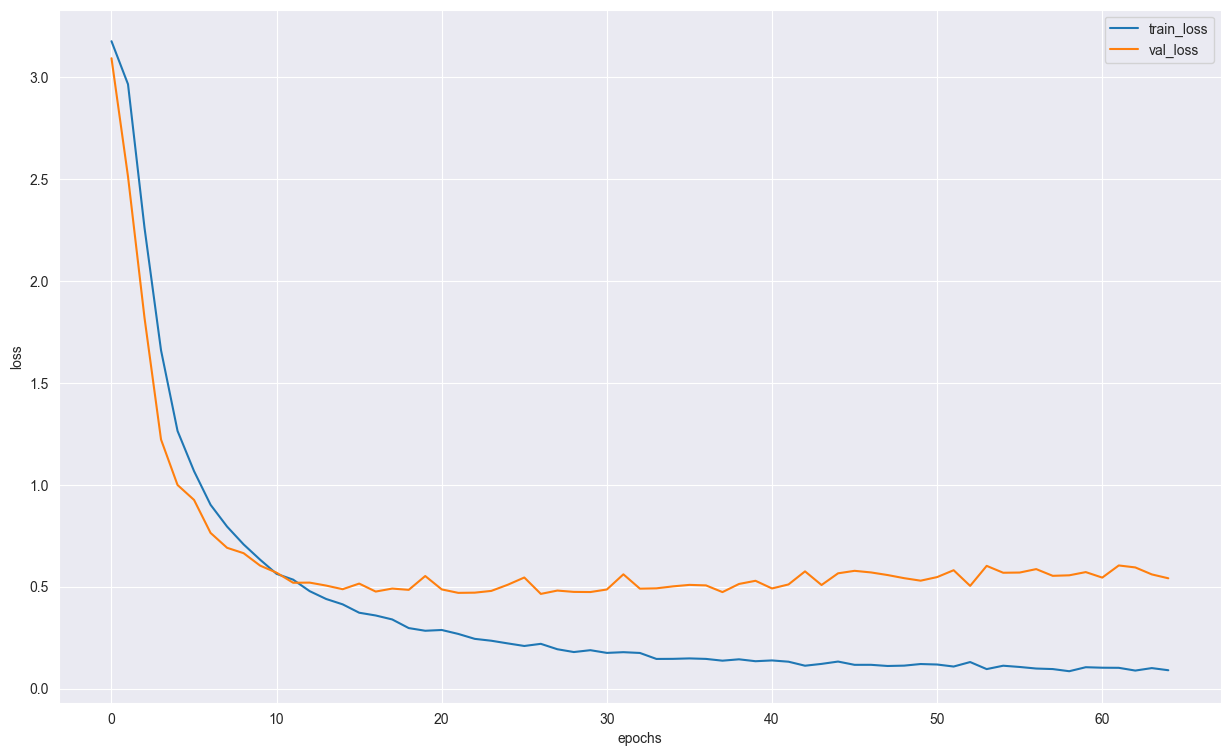

In [56]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

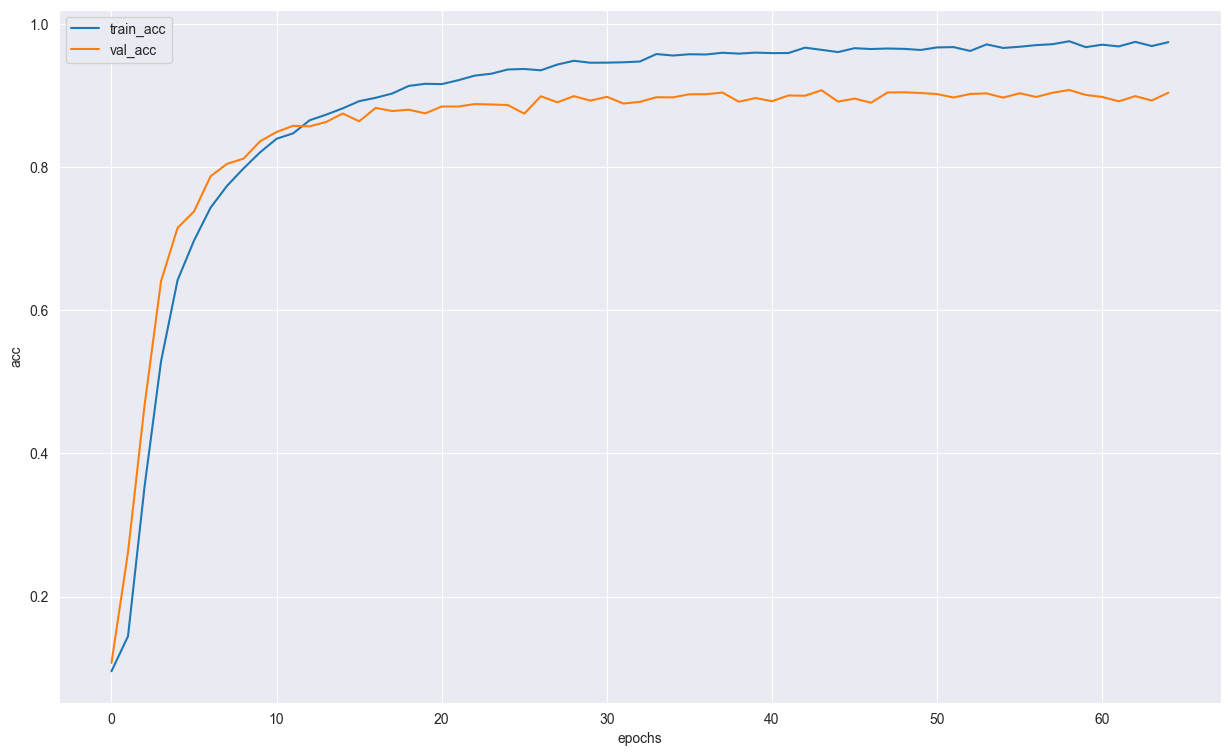

In [57]:
val_acc = [a.cpu().item() if torch.is_tensor(a) else a for a in val_acc]
acc     = [a.cpu().item() if torch.is_tensor(a) else a for a in acc]

plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

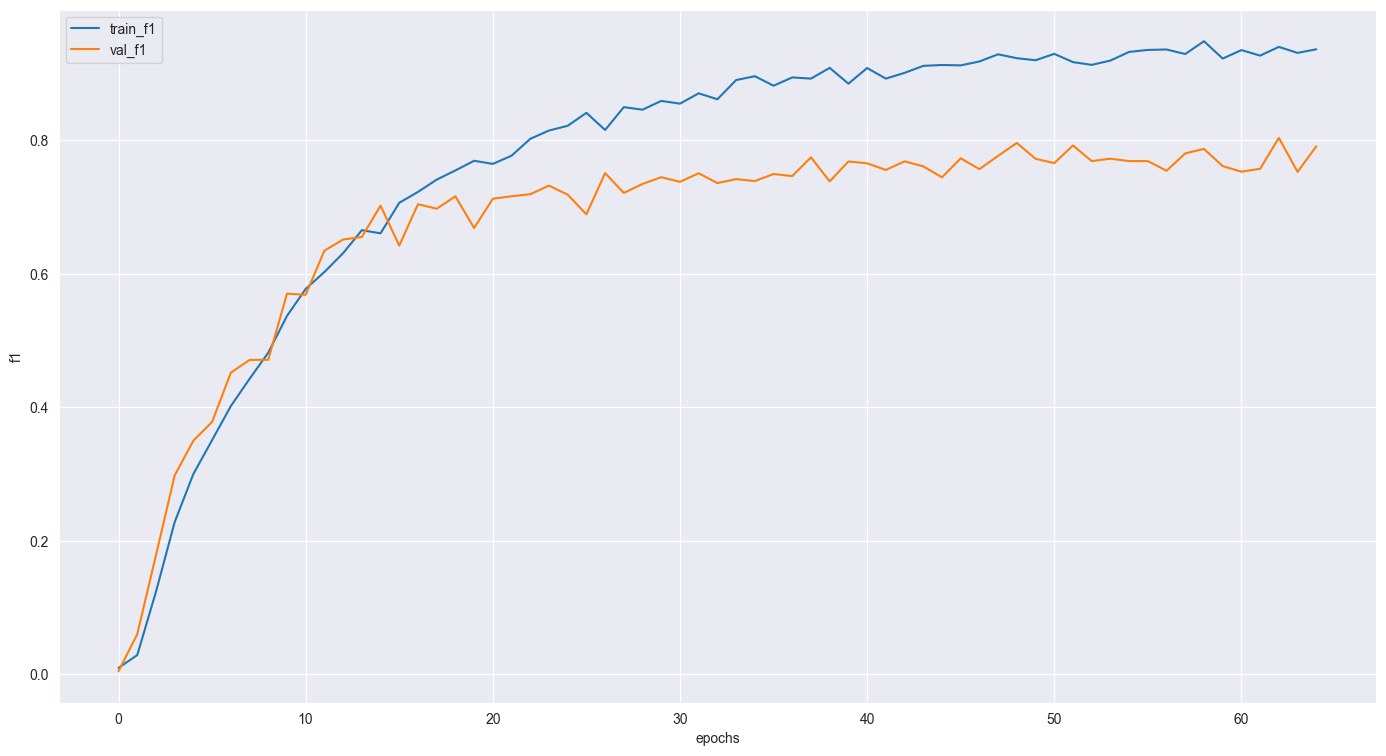

In [58]:

plt.figure(figsize=(17, 9))
plt.plot(f1, label="train_f1")
plt.plot(val_f1, label="val_f1")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("f1")
plt.show()

In [51]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
model_ml2.eval()
model_ml2.to(DEVICE)

MyCNN_MoreLayers2(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv6): Sequential(
    (0): Conv2d(256, 512, 

In [52]:
import pandas as pd
with open('label_encoder.pkl','rb') as f:
    label_encoder = pickle.load(f)

probs = predict(model_ml2, test_loader)

pred_indices = np.argmax(probs, axis=1)
pred_labels = label_encoder.inverse_transform(pred_indices)

filenames = [Path(p).name for p in test_dataset.files]

submission_df = pd.DataFrame({'Id': filenames, 'Expected': pred_labels})

submission_df.to_csv('submission_ml2.csv', index=False)
